# Weighted K-Means

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.countries`** A 2D array with the country indicator at each latitude/longitude.


* **`utils.nx`** The number of latitudes considered.


* **`utils.ny`** The number of longitudes considered.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (60,80),
(60,90),(60,100) given as input.

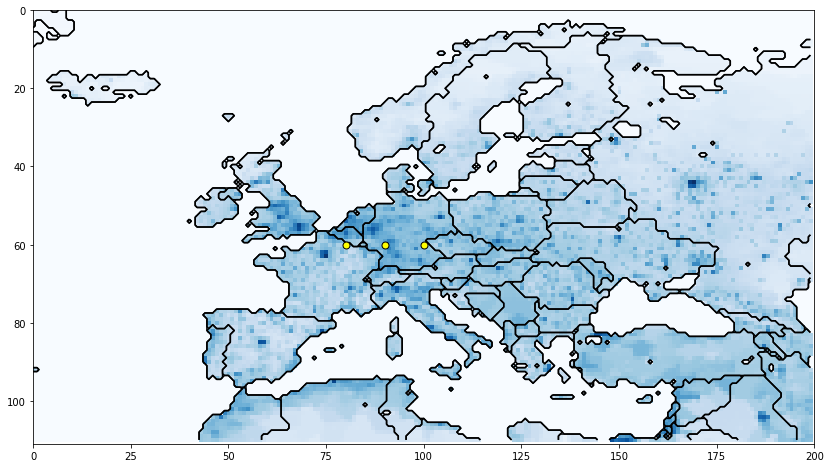

In [1]:
import utils
%matplotlib inline
utils.plot([60,60,60],[80,90,100])

## Initializing Weighted K-Means (15 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. Centroids are drawn from from the following discrete probability distribution:

$$
P(x,y) = \frac1Z \cdot \text{population}(x,y)
$$

where $Z$ is a normalization constant. Furthermore, to avoid identical centroids, we add a small Gaussian noise to the location of centroids, with standard deviation $0.01$.

**Tasks:**

* **Implement the initialization procedure above.**
* **Run the initialization procedure for K=200 clusters.**
* **Visualize the centroids obtained with your initialization procedure using `utils.plot`.**

(111, 200)


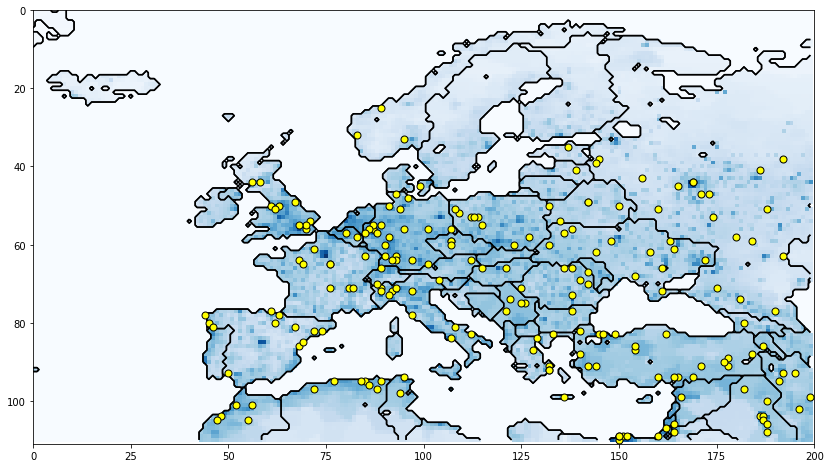

In [2]:
import numpy as np
K = 200
P = utils.population / np.sum(utils.population)
print P.shape
P_1d = P.reshape(P.shape[0]*P.shape[1])
clusters = np.random.choice(utils.ny*utils.nx, 200, p=P_1d)  # clusters are in shape [1, ny*nx], we can easily get it to 2-d format using divide and mod
latitudes = clusters / utils.ny
longitudes = clusters % utils.ny
Centroids_init = np.array(zip(latitudes, longitudes))
utils.plot(Centroids_init[:, 0], Centroids_init[:, 1])


## Implementing Weighted K-Means (30 P)

**Tasks:**


* **Implement the weighted K-Means algorithm as described in the introduction.**


* **Run the algorithm with K=200 centroids until convergence (stop if the objective does not improve by more than 0.01). Convergence should occur after less than 50 iterations. If it takes longer, something must be wrong.**


* **Print the value of the objective function at each iteration.**


* **Visualize the centroids at the end of the training procedure using the methods `utils.plot`.**

Current Iteration: 0, Current Cost: 3196.79203329 
Current Iteration: 1, Current Cost: 9.8352169968 
Current Iteration: 2, Current Cost: 9.13884098441 
Current Iteration: 3, Current Cost: 8.73890839206 
Current Iteration: 4, Current Cost: 8.28433472853 
Current Iteration: 5, Current Cost: 8.02944829186 
Current Iteration: 6, Current Cost: 7.69910585599 
Current Iteration: 7, Current Cost: 7.52082094174 
Current Iteration: 8, Current Cost: 7.35718256588 
Current Iteration: 9, Current Cost: 7.30456133833 
Current Iteration: 10, Current Cost: 7.27647444312 
Current Iteration: 11, Current Cost: 7.24832521939 
Current Iteration: 12, Current Cost: 7.22674830004 
Current Iteration: 13, Current Cost: 7.20651226993 
Current Iteration: 14, Current Cost: 7.18930772688 
Current Iteration: 15, Current Cost: 7.17564855059 
Current Iteration: 16, Current Cost: 7.14741059138 
Current Iteration: 17, Current Cost: 7.10935927946 
Current Iteration: 18, Current Cost: 7.09824100402 
Current Iteration: 19, 

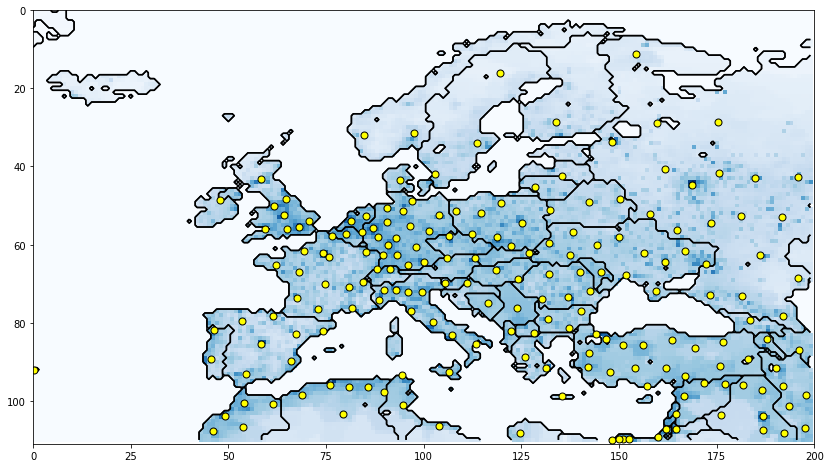

In [22]:
def get_W(W, x):
    return W[x[0]][x[1]] #to be checked

def choose_closest_centroid(Centroids, x):
    # Centroids -- [N*2]
    # x -- [1, 2]
    return np.argmin(np.sum((Centroids-x)**2, axis=1))

def calc_cost(Centroids, W, Clustering_points):
    # X -- [Nx*Ny , 2]
    # W -- [Nx , Ny]
    # Centroids -- [K , 2]
    cost = 0
    K = Centroids.shape[0]
    cost_dividend = 0
    cost_divisor = 0
    for j in range(K):
        for i in Clustering_points[j]:
            dist = np.sum((i-Centroids[j])**2)
            cost_dividend += get_W(W, i)*dist
            cost_divisor += get_W(W, i)
    if(cost_divisor != 0):
        cost += cost_dividend/cost_divisor
    return cost

def E_step(Centroids, X):
    # X -- [Nx*Ny, 2]
    # Centroids -- [K, 2]
    K = Centroids.shape[0]
    Clustering_points = [[] for t in range(K)]
    for i in X:
        target_slot = choose_closest_centroid(Centroids, i)
        Clustering_points[target_slot].append((i.reshape(2)[0], i.reshape(2)[1]))
    return np.array(Clustering_points)

def M_step(Clustering_points, W, X):
    K = Clustering_points.shape[0]
    Centroids = []
    for i in range(K):
        cost_dividend = np.zeros((1, 2))
        cost_divisor = 0
        for j in Clustering_points[i]:
            cost_dividend = cost_dividend + np.array(j)*get_W(W, j)
            cost_divisor = cost_divisor + get_W(W, j)
        if(cost_divisor != 0):
            tmp = (cost_dividend/cost_divisor).reshape(2)
            Centroids.append((tmp[0], tmp[1]))
    return np.array(Centroids)

def run_k_clustering(Centroids, W, X):
    prev_cost = 999999
    cur_cost = 0
    iteration = 0
    while(abs(cur_cost - prev_cost) >= 0.01 and iteration < 50):
        prev_cost = cur_cost
        # E_step
        Clustering_points = E_step(Centroids, X)
        # M_step
        Centroids = M_step(Clustering_points, W, X)
        # cost
        cur_cost = calc_cost(Centroids, W, Clustering_points)
        print 'Current Iteration: {0}, Current Cost: {1} '.format(iteration, cur_cost)
        iteration += 1
    print "finished"
    return Centroids

data_y = np.nonzero(utils.population)[0]
data_x = np.nonzero(utils.population)[1]
data_flatten = np.array(zip(data_y, data_x))
Centroids_final= run_k_clustering(Centroids_init, P, data_flatten)
utils.plot(Centroids_final[:, 0], Centroids_final[:, 1])